In [6]:
import os
import scenic
# scenic_script = "./examples/carla/Carla_Challenge/carlaChallenge5.scenic"
scenic_script = "./examples/carla/test2.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

# from scenic.domains.driving.roads import ManeuverType, Network
# map_path = '/Users/edwardkim/Desktop/Scenic-devel/examples/carla/../../tests/formats/opendrive/maps/CARLA/Town05.xodr'
# network = Network.fromFile(map_path)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


In [40]:
from scenic.core.vectors import OrientedVector, Vector
import shapely.geometry
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion
import os.path as path

resetConditionedObj(scenario)
sample = scenario.egoObject.sample()
print(sample.position)
print(sample.heading)
print(math.degrees(sample.heading))

(-157.02507219932716 @ -0.36299354159635033)
1.5732303721499772
90.13946052598955


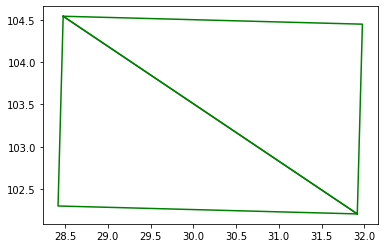

NotImplementedError: 

In [44]:

from scenic.core.distributions import *
from scenic.core.vectors import Vector
from scenic.core.regions import SectorRegion
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isPositionValid(obj, label, smt_file_path, ego_info, debug=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    cached_variables = {}
    cached_variables['variables'] = []
    cached_variables['current_obj_pos'] = (label.position.x, label.position.y)
    
    # Create Ego's VisibleRegion
    ego_labelled_position = Vector(label.position.x, label.position.y)
    ego_visibleDistance = ego_info['visibleDistance']
    ego_viewAngle = ego_info['viewAngle']
    ego_labelled_heading = ego_info['headingAngle']
    egoVisibleRegion = SectorRegion(ego_labelled_position, ego_visibleDistance, \
                                    ego_labelled_heading, ego_viewAngle)
    cached_variables['egoVisibleRegion'] = egoVisibleRegion.polygon
    
    # Encode object's position to SMT formula
    pos_smt_var = obj.position.encodeToSMT(smt_file_path, cached_variables, debug = debug)

    if pos_smt_var is None:
        print("NOT FEASIBLE POSITION: "+ str(cached_variables['current_obj_pos']))
        return False

    else:
        (x_cond, y_cond) = vector_operation_smt(pos_smt_var, "equal", (str(label.position.x), str(label.position.y)))
        writeSMTtoFile(smt_file_path, smt_assert(None, x_cond))
        writeSMTtoFile(smt_file_path, smt_assert(None, y_cond))
        writeSMTtoFile(smt_file_path, "(check-sat)")
        writeSMTtoFile(smt_file_path, "(exit)")

        if not debug:
            if subprocess.call("./run_smt_encoding.sh") == 1:
                return True
            else:
                return False
        else:
            print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None


ego_visibleDistance = 100 #meters
ego_viewAngle = 135 #deg
ego_sample = scenario.egoObject.sample()
ego_info = {
    'visibleDistance' : ego_visibleDistance,
    'viewAngle' : math.radians(ego_viewAngle), #radians,
    'headingAngle' : ego_sample.heading #radians
}

smt_file_path = './test_smt_encoding.smt2'
resetConditionedObj(scenario)
obj = scenario.egoObject
label = obj.sample()
print(isPositionValid(obj, label, smt_file_path, ego_info, debug=True))

In [ ]:
print(ego_pos_smt_var)

In [ ]:
import subprocess
x = subprocess.call("./run_smt_encoding.sh")
print(x)